In [1]:
import pandas as pd
import numpy as np


from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as sklmrg
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import model_selection

import statsmodels.formula.api as smf

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

from scipy import stats

import cudf
from cuml import LinearRegression as culmrg
from cuml.ensemble import RandomForestRegressor as curfr
from cuml.metrics.regression import mean_absolute_error as mae
from cuml.metrics.regression import mean_squared_log_error as rmse
# from cuml.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loan = pd.read_csv('/datasets/loan_data/loan_p_reg.csv')
# loan= loan.iloc[0:100]
print(loan.shape)
#print(loan.columns)
loan.head()

(3387379, 20)


,year,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,purpose_cat,interest_payments,interest_payment_cat,loan_condition_cat,interest_rate,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment,region
0,4,10.0,1,24000,1,5000,1,1,1,1,1,0,10.65,2,27.65,5861.071414,5000.00,0.00,162.87,3
1,4,0.5,1,30000,1,2500,2,1,2,0,2,1,15.27,3,1.00,1008.710000,456.46,117.08,59.83,2
2,4,10.0,1,12252,1,2400,1,1,3,0,2,0,15.96,3,8.72,3003.653644,2400.00,0.00,84.33,1
3,4,10.0,1,49200,1,10000,1,1,4,0,2,0,13.49,3,20.00,12226.302210,10000.00,0.00,339.31,4
4,4,1.0,1,80000,1,3000,2,1,4,1,1,0,12.69,2,17.94,3242.170000,2233.10,0.00,67.79,4


## Regression
### Rescale and split data to training and testing sets 

In [3]:
loan1 = loan[-loan.loan_condition_cat.isin([0])]
X = loan1.drop(['total_pymnt'], axis=1) 
cols = ['year', 'emp_length_int', 'home_ownership_cat', 'annual_inc', 'income_cat', 'loan_amount',
        'term_cat', 'application_type_cat', 'purpose_cat', 'interest_payments', 'interest_payment_cat', 'loan_condition_cat',
        'interest_rate', 'grade_cat', 'dti', 'total_rec_prncp', 'recoveries', 'installment','region']

y = loan1['total_pymnt']
y = pd.Series(y.astype(np.int32))
X


,year,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,purpose_cat,interest_payments,interest_payment_cat,loan_condition_cat,interest_rate,grade_cat,dti,total_rec_prncp,recoveries,installment,region
1,4,0.500000,1,30000,1,2500,2,1,2,0,2,1,15.270000,3,1.000000,456.460000,117.080000,59.830000,2
8,4,4.000000,2,40000,1,5600,2,1,3,0,2,1,21.280000,6,5.550000,162.020000,189.060000,152.390000,4
9,4,0.500000,1,15000,1,5375,2,1,4,1,1,1,12.690000,2,18.080000,673.480000,269.290000,121.450000,3
12,4,0.500000,1,30000,1,9000,1,1,6,0,2,1,13.490000,3,10.080000,1256.140000,444.300000,305.380000,2
14,4,3.000000,1,100000,1,10000,1,1,4,1,1,1,10.650000,2,7.060000,5433.470000,645.100000,325.740000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387369,2,8.489319,3,76668,1,16000,1,1,8,1,2,1,12.974106,7,10.281850,7976.326200,-13.043855,178.460193,0
3387375,2,1.912267,2,72000,2,9000,1,1,4,0,1,1,12.904449,1,10.286255,26270.937768,1097.056552,626.756473,1
3387376,2,7.794629,2,45000,1,7800,1,1,5,0,1,1,11.892682,6,10.512935,16529.571581,835.841975,102.772198,0
3387377,2,6.191142,1,110000,1,10000,1,1,2,0,2,1,7.990608,6,4.215931,9183.373693,942.409839,143.417421,4


In [4]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = preprocessing.scale(X_train)
X_train = pd.DataFrame(X_train, columns = cols)
X_train = pd.DataFrame(X_train.astype(np.float32))

X_test = preprocessing.scale(X_test)
X_test = pd.DataFrame(X_test, columns = cols)
X_test = pd.DataFrame(X_test.astype(np.float32))

### Feature Selection

In [5]:
def processSubset(X_label, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    X_smf = ' + '.join(X_label)
    f     = 'total_pymnt ~ {}'.format(X_smf)
    # Fit model
    lin_reg = smf.ols(formula=f, data=pd.concat([X_train, y_train], axis=1)).fit()
    RSS = ((lin_reg.predict(X_test[list(X_label)]) - y_test) ** 2).sum() #on test set
    return {'model': lin_reg, 'RSS': RSS}

In [6]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [7]:
models_test = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_test.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    exog = models_test.loc[i]['model'].model.exog_names.copy()
    exog.remove('Intercept')
    predictors = exog
    print(i, predictors)

1 ['year']
2 ['year', 'emp_length_int']
3 ['year', 'emp_length_int', 'installment']
4 ['year', 'emp_length_int', 'installment', 'grade_cat']
5 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments']
6 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_cat']
7 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_cat', 'application_type_cat']
8 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_cat', 'application_type_cat', 'loan_condition_cat']
9 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_cat', 'application_type_cat', 'loan_condition_cat', 'interest_payment_cat']
10 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_cat', 'application_type_cat', 'loan_condition_cat', 'interest_payment_cat', 'home_ownership_cat']
11 ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments', 'income_c

7


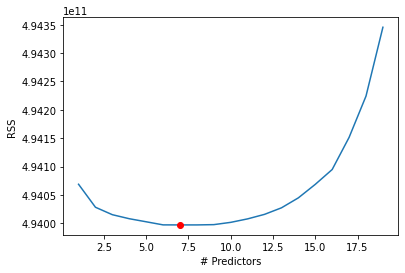

In [8]:
sns.lineplot(x=range(1,20), y=models_test['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_test['RSS'].argmin()+1, models_test['RSS'].min(), 'or')
print(models_test['RSS'].argmin()+1)

### Define function to compute  MAE and RMSE value both of training and testing set with different model

In [9]:
def regression_cu(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_ts = model.predict(X_test)
    pred_tr = model.predict(X_train)
    
    y_train = pd.Series(y_train.astype(np.int32))
    y_test = pd.Series(y_test.astype(np.int32))
    
    pred_ts = pd.Series(pred_ts.astype(np.int32))
    pred_tr = pd.Series(pred_tr.astype(np.int32))
    
  
    train_mae = mean_absolute_error(y_train, pred_tr) 
    train_rmse = mean_squared_error(y_train, pred_tr, squared=False)
    print ("Training set MAE: {:.5}".format(train_mae))
    print ("Training set RMSE: {:.5}".format(train_rmse)) 
        
    test_mae = mae(y_test, pred_ts)
    test_rmse = mean_squared_error(y_test, pred_ts, squared=False)
    print ("Testing set MAE : {:.5}".format(test_mae))
    print ("Testing set RMSE: {:.5}".format(test_rmse))
    

### Linear Regression

In [10]:
#predictor_var = ['home_ownership_cat', 'installment', 'grade_cat', 'emp_length_int']
predictor_var = ['year', 'emp_length_int', 'installment', 'grade_cat', 'interest_payments'
                 , 'income_cat', 'application_type_cat']

In [11]:
lr_model = culmrg(fit_intercept = True)
regression_cu(lr_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set MAE: 5785.2
Training set RMSE: 7191.0
Testing set MAE : 5783.7
Testing set RMSE: 7188.6


### Decision tree 

In [12]:
dt_model = DecisionTreeRegressor(random_state=0)
regression_cu(dt_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set MAE: 16.436
Training set RMSE: 245.94
Testing set MAE : 7849.9
Testing set RMSE: 1.0035e+04


### Random Forest

In [13]:
rf_model = curfr(max_features=1.0, n_bins=128, min_samples_leaf=1, 
                   min_samples_split=2, n_estimators=40, accuracy_metric='r2', 
                   random_state=1, n_streams=1)
regression_cu(rf_model, X_train[predictor_var], X_test[predictor_var], y_train, y_test)

Training set MAE: 5374.0
Training set RMSE: 6725.3
Testing set MAE : 5995.0
Testing set RMSE: 7678.6


### Linear Regression using quadratic polynomial

In [14]:
# quadratic polynomial
# include bias = False, will not return the constant value, that is X**0, as that is added automatically by lin regression
poly = PolynomialFeatures(2, include_bias=False)
poly.fit(X_train[predictor_var])
X_train_quad = poly.transform(X_train[predictor_var])
X_test_quad = poly.transform(X_test[predictor_var])
lrq_model = culmrg()
regression_cu(lrq_model, X_train_quad, X_test_quad , y_train, y_test)


Training set MAE: 5697.1
Training set RMSE: 7133.5
Testing set MAE : 5716.6
Testing set RMSE: 7129.0


### Leave-One-Out Cross-Validation¶

In [15]:
#tmp = X_train[predictor_var]
#tmp = X[predictor_var]
# loocv = LeaveOneOut()
# loocv.get_n_splits(tmp)

# tr_loocv_mae = []
# tr_loocv_rmse = []

# ts_loocv_mae = []
# ts_loocv_rmse = []

# lm = culmrg()

# for i in tqdm(range(1,len(tmp)+1)):
#     for train_index, test_index in loocv.split(tmp):
#         X_train, X_test = tmp.iloc[train_index], tmp.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#         lm_fit = lm.fit(X_train, y_train)
#         lm_pred_tr = lm_fit.predict(X_train)
#         lm_pred_ts = lm_fit.predict(X_test)
    
#         tr_loocv_mae.append(mean_absolute_error(y_train, lm_pred_tr))
#         tr_loocv_rmse.append(mean_squared_error(y_train, lm_pred_tr, squared=False))
    
    
#         ts_loocv_mae.append(mean_absolute_error(y_test, lm_pred_ts))
#         ts_loocv_rmse.append(mean_squared_error(y_test, lm_pred_ts, squared=False))
    

# print ("Training set MAE: {:.5}".format(np.array(tr_loocv_mae).mean()))
# print ("Training set RMSE: {:.5}".format(np.array(tr_loocv_rmse).mean())) 
# print ("Testing set MAE : {:.5}".format(np.array(ts_loocv_mae).mean()))
# print ("Testing set RMSE: {:.5}".format(np.array(ts_loocv_rmse).mean()))

## LocalCUDACluster

In [19]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from dask.utils import parse_bytes
import cudf
import dask_cudf

cluster = LocalCUDACluster(
    CUDA_VISIBLE_DEVICES="0",
    rmm_pool_size=parse_bytes("45GB"), # This GPU has 48GB of memory
    device_memory_limit=parse_bytes("40GB"),
)
client = Client(cluster)
client

/opt/miniconda3/envs/rapids/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36425 instead
  warnings.warn(
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:36425/status,
Dashboard: http://127.0.0.1:36425/status,Workers: 1
Total threads: 1,Total memory: 503.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41103,Workers: 1
Dashboard: http://127.0.0.1:36425/status,Total threads: 1
Started: Just now,Total memory: 503.77 GiB
Comm: tcp://127.0.0.1:40913,Total threads: 1
Dashboard: http://127.0.0.1:43651/status,Memory: 503.77 GiB
Nanny: tcp://127.0.0.1:40827,


## $k$-Fold Cross-Validation

In [20]:
tr_kf_mae = []
ts_kf_mae = []
tr_kf_rmse = []
ts_kf_rmse = []

lm = culmrg()
#tmp = X_train[predictor_var]
tmp = X[predictor_var]
kf = KFold(n_splits=5 , shuffle=True, random_state=1)
for i in tqdm(range(1,6)):
    for train_index, test_index in kf.split(tmp):
        X_train, X_test = tmp.iloc[train_index], tmp.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        poly = PolynomialFeatures(i,include_bias=False)
        poly.fit(X_train)
        X_train_2 = poly.transform(X_train)
        X_test_2 = poly.transform(X_test)
        
        lm_fit = lm.fit(X_train_2, y_train)
        lm_pred_tr = lm_fit.predict(X_train_2)
        lm_pred_ts = lm_fit.predict(X_test_2)
        
        tr_kf_mae.append(mean_absolute_error(y_train, lm_pred_tr))
        ts_kf_mae.append(mean_absolute_error(y_test, lm_pred_ts))
        
        tr_kf_rmse.append(mean_squared_error(y_train, lm_pred_tr, squared=False))
        ts_kf_rmse.append(mean_squared_error(y_test, lm_pred_ts, squared=False))
        

print ("Training set MAE: {:.5}".format(np.array(tr_kf_mae).mean()))
print ("Training set RMSE: {:.5}".format(np.array(tr_kf_rmse).mean())) 
print ("Testing set MAE : {:.5}".format(np.array(ts_kf_mae).mean()))
print ("Testing set RMSE: {:.5}".format(np.array(ts_kf_rmse).mean()))


100%|██████████| 5/5 [02:14<00:00, 26.83s/it]

Training set MAE: 1.926e+07
Training set RMSE: 3.2071e+07
Testing set MAE : 1.9238e+07
Testing set RMSE: 3.5501e+07


### Dimension reduction with PCA

/opt/miniconda3/envs/rapids/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/rapids/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/rapids/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 409, in inner_with_setters
    return func(*args, **kwargs)
  File "cuml/linear_model/linear_regression.pyx", line 295, in cuml.linear_model.linear_regression.LinearRegression.fit
Ru

Text(0.5, 1.0, 'total_pymnt')

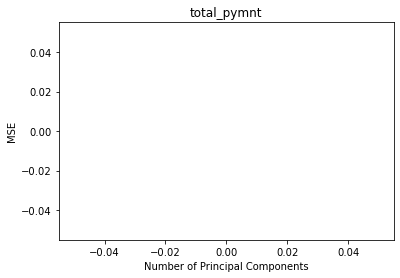

In [18]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(preprocessing.scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = culmrg(algorithm = "svd")
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('total_pymnt')

### PCR

In [ ]:
X_red_tr = pca.fit_transform(X_train)
X_red_ts = pca.transform(X_test)

pcr = culmrg(algorithm = "svd")
pcr.fit(X_red_tr, y_train)

pred_pcr_tr = pcr.predict(X_red_tr)
pred_pcr_ts = pcr.predict(X_red_ts)

print ("Training set MAE: {:.5}".format(mean_absolute_error(y_train, pred_pcr_tr)))
print ("Training set RMSE: {:.5}".format(mean_squared_error(y_train, pred_pcr_tr, squared=False))) 
print ("Testing set MAE : {:.5}".format(mean_absolute_error(y_test, pred_pcr_ts)))
print ("Testing set RMSE: {:.5}".format(mean_squared_error(y_test, pred_pcr_ts, squared=False)))